In [18]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

basket = pd.read_csv("Groceries_dataset.csv")
display(basket.head())

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [19]:
basket.itemDescription = basket.itemDescription.transform(lambda x: [x])
basket = basket.groupby(['Member_number','Date']).sum()['itemDescription'].reset_index(drop=True)

encoder = TransactionEncoder()
transactions = pd.DataFrame(encoder.fit(basket).transform(basket), columns=encoder.columns_)
display(transactions.head())

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
frequent_itemsets = apriori(transactions, min_support= 6/len(basket), use_colnames=True, max_len = 2)
rules = association_rules(frequent_itemsets, metric="lift",  min_threshold = 1.5)
display(rules.head())
print("Rules identified: ", len(rules))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(UHT-milk),(butter milk),0.021386,0.017577,0.000601,0.028125,1.600131,0.000226,1.010854,0.383247
1,(butter milk),(UHT-milk),0.017577,0.021386,0.000601,0.034221,1.600131,0.000226,1.013289,0.381761
2,(UHT-milk),(cream cheese ),0.021386,0.023658,0.000869,0.040625,1.717152,0.000363,1.017685,0.426767
3,(cream cheese ),(UHT-milk),0.023658,0.021386,0.000869,0.036723,1.717152,0.000363,1.015922,0.427761
4,(soda),(artif. sweetener),0.097106,0.001938,0.000468,0.004818,2.485725,0.000280,1.002893,0.661986


Rules identified:  190


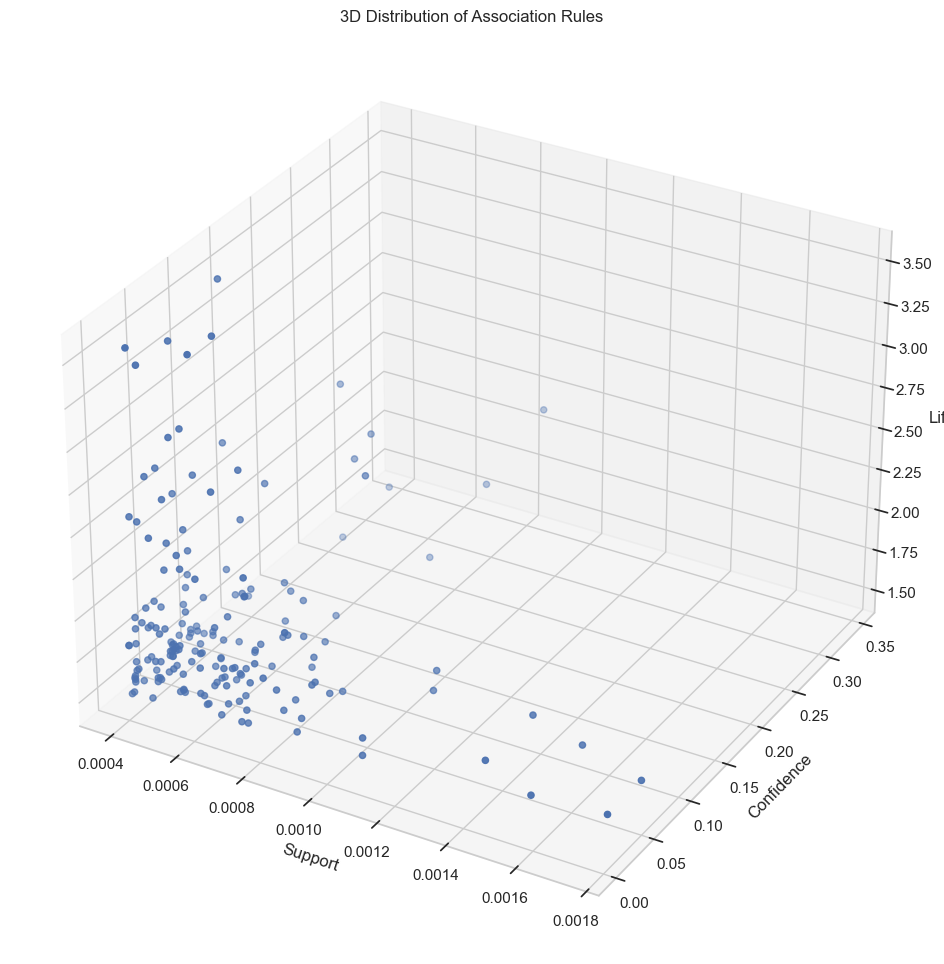

In [21]:
sns.set(style = "whitegrid")
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection = '3d')

x = rules['support']
y = rules['confidence']
z = rules['lift']

ax.set_xlabel("Support")
ax.set_ylabel("Confidence")
ax.set_zlabel("Lift")

ax.scatter(x, y, z)
ax.set_title("3D Distribution of Association Rules")

plt.show()

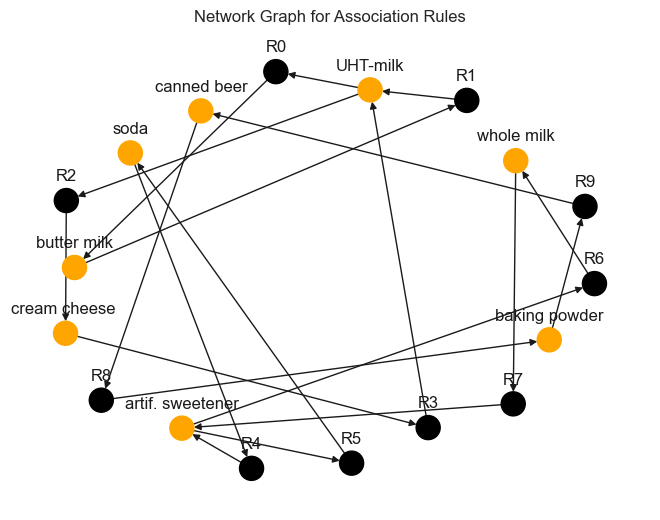

In [23]:
def draw_network(rules, rules_to_show):
  # Directional Graph from NetworkX
  network = nx.DiGraph()
  
  # Loop through number of rules to show
  for i in range(rules_to_show):
    
    # Add a Rule Node
    network.add_nodes_from(["R"+str(i)])
    for antecedents in rules.iloc[i]['antecedents']: 
        # Add antecedent node and link to rule
        network.add_nodes_from([antecedents])
        network.add_edge(antecedents, "R"+str(i),  weight = 2)
      
    for consequents in rules.iloc[i]['consequents']:
        # Add consequent node and link to rule
        network.add_nodes_from([consequents])
        network.add_edge("R"+str(i), consequents,  weight = 2)

  color_map=[]  
  
  # For every node, if it's a rule, colour as Black, otherwise Orange
  for node in network:
       if re.compile("^[R]\d+$").fullmatch(node) != None:
            color_map.append('black')
       else:
            color_map.append('orange')
  
  # Position nodes using spring layout
  pos = nx.spring_layout(network, k=16, scale=1)
  # Draw the network graph
  nx.draw(network, pos, node_color = color_map, font_size=8)            
  
  # Shift the text position upwards
  for p in pos:  
      pos[p][1] += 0.12

  nx.draw_networkx_labels(network, pos)
  plt.title("Network Graph for Association Rules")
  plt.show()

draw_network(rules, 10)

In [24]:
milk_rules = rules[rules['consequents'].astype(str).str.contains('whole milk')]
milk_rules = milk_rules.sort_values(by=['lift'],ascending = [False]).reset_index(drop = True)

display(milk_rules.head())

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(brandy),(whole milk),0.002540,0.157923,0.000869,0.342105,2.166281,0.000468,1.279957,0.539750
1,(softener),(whole milk),0.002740,0.157923,0.000802,0.292683,1.853328,0.000369,1.190523,0.461695
2,(canned fruit),(whole milk),0.001403,0.157923,0.000401,0.285714,1.809201,0.000179,1.178908,0.447899
3,(syrup),(whole milk),0.001403,0.157923,0.000401,0.285714,1.809201,0.000179,1.178908,0.447899
4,(artif. sweetener),(whole milk),0.001938,0.157923,0.000535,0.275862,1.746815,0.000229,1.162868,0.428360
